# 연구 목표

> 자연어 처리 분야에서 컴퓨터에게 언어를 효율으로 학습시키기 위해, 다양한 머신러닝 알고리듬이 연구되었고 기존 하드웨어 성능의 한계로 인한 문제가 개선됨에 따라 자연어를 딥러닝에 적용하는 연구도 활발하게 진행되고 있다. 이에, 본 연구에서는 Keras사에서 제공하는 '로이터 뉴스(Reuters News)' 데이터를 활용하여 머신러닝 알고리듬과 딥러닝 모델의 성능을 비교하고, 모델에서 사용하는 단어 수(vacabulary size)의 차이가 모델 성능에 영향을 미치는지 분석하는 실험을 진행한다.

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras import backend as K
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

# 1. Reuters News Data EDA

> 본 1장에서는 데이터 전처리 이전에 Reuters News 데이터의 특징을 분석하는 과정을 기술한다.

## 1.1 Data Load

> Reuters News 데이터를 8:2 비율로 학습 데이터와 테스트 데이터로 분할하여 데이터를 메모리에 할당한다.

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [3]:
print(f'학습 데이터 text 개수: {len(x_train)}')
print(f'학습 데이터 label 개수: {len(y_train)}')
print(f'테스트 데이터 text 개수: {len(x_test)}')
print(f'테스트 데이터 label 개수: {len(y_test)}')

학습 데이터 text 개수: 8982
학습 데이터 label 개수: 8982
테스트 데이터 text 개수: 2246
테스트 데이터 label 개수: 2246


> 학습 데이터는 8,982개, 테스트 데이터는 2246개이다.

## 1.2 Data Feature Analysis

### 1.2.1 뉴스 주제 종류 분석

> Reuters News는 뉴스 주제(카테고리)를 라벨에 분류하여 표기하였고, 이를 활용하여 카데고리의 개수를 분석한다.<br>

In [4]:
set_lable = set(y_test)
news_label = max(set_lable)+1

print(f'뉴스 주제(카테고리)의 종류 가지 수 : {news_label}')

뉴스 주제(카테고리)의 종류 가지 수 : 46


> Reuters News는 46가지의 주제가 분포되어있음을 확인할 수 있다.

### 1.2.2 본문의 단어 종류 분석

> 본문 텍스트의 종류 개수를 분석한 결과는 아래와 같다.

In [5]:
df_sentence = np.concatenate((x_train, x_test), axis=0)
print(f"Reuters News의 본문 개수 : {len(df_sentence)} 개")

df_text = set()
for sentence in df_sentence:
    df_text.update(sentence)
    
print(f"Reuters News의 단어 종류 개수 : {len(df_text)} 가지")

Reuters News의 본문 개수 : 11228 개
Reuters News의 단어 종류 개수 : 30980 가지


> 뉴스 본문은 11,228 개 이며, 본문에 사용된 단어의 종류는 30,980 가지이다.

## 1.3 Data Distribution analysis

> Reuters News의 본문과 주제의 구성를 분석하기 위한 분포도를 확인한다.

### 1.3.1 뉴스 본문 데이터 분포도 분석

> Reuters News 본문 데이터의 분포를 분석하기위한 사용자 정의 함수를 구현한다.

In [6]:
def print_distribution_data(df_data, title='데이터'):
    print(f'{title}의 본문 최대 길이 :{max(len(l) for l in df_data)}')
    print(f'{title}의 본문 평균 길이 :{sum(map(len, x_train))/len(x_train)}')

    plt.hist([len(s) for s in df_data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

> 학습 데이터의 뉴스 본문 분포도를 분석한 결과 가장 긴 뉴스 본문은 2,376자, 평균 145자이다.

학습 데이터의 본문 최대 길이 :2376
학습 데이터의 본문 평균 길이 :145.5398574927633


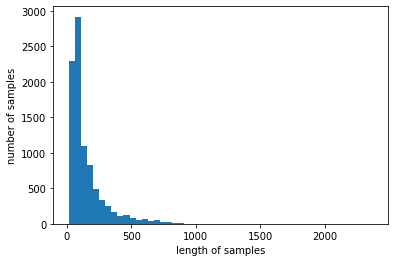

In [7]:
print_distribution_data(x_train, '학습 데이터')

> 테스트 데이터의 뉴스 본문 분포도를 분석한 결과 가장 긴 뉴스 본문은 1,032자, 평균 145자이다.

테스트 데이터의 본문 최대 길이 :1032
테스트 데이터의 본문 평균 길이 :145.5398574927633


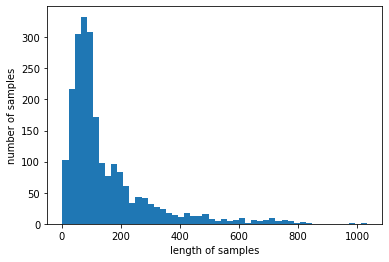

In [8]:
print_distribution_data(x_test, '테스트 데이터')

### 1.3.2 뉴스 주제 데이터 분포도 분석

> Reuters News 데이터의 주제(카테고리) 분포를 분석하기위한 사용자 정의 함수를 구현한다.

In [9]:
def print_distribution_category(df_data):
    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    sns.countplot(x=df_data)
    plt.show()

> 학습 데이터의 뉴스 주제 분포도를 분석한 결과 가장 높은 빈도는 '3'이고, 이어서 '4', '19', '16', '1' 순으로 빈도가 높았다.

In [10]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
display(pd.DataFrame(np.asarray((unique_elements, counts_elements))))

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
1,55,432,74,3159,1949,17,48,16,139,101,...,49,19,19,24,36,30,13,21,12,18


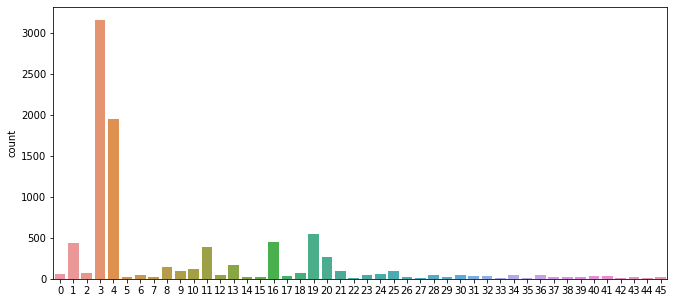

In [11]:
print_distribution_category(y_train)

> 테스트 데이터의 뉴스 주제 분포도를 분석한 결과, 학습 데이터의 분포도와 동일한 비율의 결과를 보여주었다.

In [12]:
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
display(pd.DataFrame(np.asarray((unique_elements, counts_elements))))

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
1,12,105,20,813,474,5,14,3,38,25,...,11,2,3,5,10,8,3,6,5,1


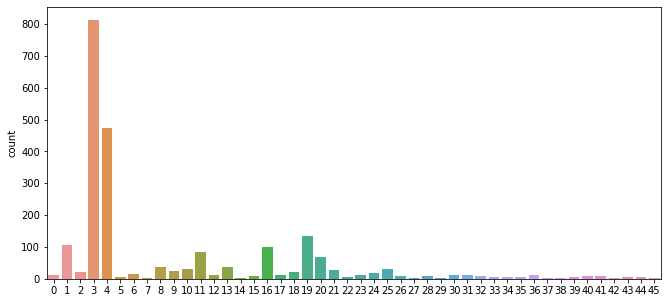

In [13]:
print_distribution_category(y_test)

# 2. Data Preprocessing

> 본 2 장에서는 자연어 처리 모델에 활용할 단어장을 생성하는 과정을 기술한다.

## 2.1 단어장 생성

> Keras사에서 제공하는 '로이터 뉴스(Reuters News)' library의 word to index.json을 활용하여 Vocabulary를 생성한다.<br>
> Reuters News의 word2index의 index는 +3을 했을때 고유 번호이므로, 1번 인덱스를 4번으로 옮기는 작업을 진행한다.

In [14]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = {index+3 : word for word, index in word_index.items()}
print("vocabulary size:", len(index_to_word))

vocabulary size: 30979


> 위 작업으로 사용되지 않는 0~2번 index에 pad, sos, unk 토큰을 추가하여, 단어장의 총 크기는 30,982이다.

In [15]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token
print("vocabulary size:", len(index_to_word))

vocabulary size: 30982


## 2.2 단어장을 활용한 문장 복원 실험

> 위 2.1장에서 구성한 vocabulary를 활용하여 학습 데이터와 테스트 데이터의 문장을 복원하는 실험을 위한 사용자 정의 함수를 구현한다.

In [16]:
def decode_index_to_word(df_data):
    decoded = []
    for i in range(len(df_data)):
        decoded += [' '.join([index_to_word[index] for index in df_data[i]])]
        
    return decoded

> 학습 데이터의 정수형 시퀀스 데이터를 문자형 데이터로 복원하였을때 결과는 아래와 같다.<br>
> 단어장에 등록되지 않은 단어는 정수형 데이터로 표현함을 확인할 수 있다.

In [17]:
train_data = decode_index_to_word(x_train)
train_data[-1:]

["<sos> currency fluctuations may reassert their influence on the bullion market in the near future bullion bankers samuel montagu and co ltd said in a market report but the firm said silver may lag behind gold in any reactions to movements on foreign exchanges opec's failure to address the recent decline in oil prices remains a worrying factor however and on balance it appears that the market should be approached cautiously montagu said the bank said the us economy has shown no noticeable long term improvement and that both latin american debt and the iranian arms affair could undermine confidence in the dollar reuter 3"]

> 테스트 데이터의 정수형 시퀀스 데이터를 문자형 데이터로 복원하였을때 결과는 아래와 같다.<br>
> 단어장에 등록되지 않은 일부 단어는 정수형 데이터로 표현함을 확인할 수 있다.

In [18]:
test_data = decode_index_to_word(x_test)
test_data[-1:]

["<sos> congress should give the u s agriculture secretary the authority to keep the 1987 soybean loan rate at the current effective rate of 4 56 dlrs per bushel in order to help resolve the problem of soybean export competitiveness usda undersecretary dan amstutz said speaking to reporters following a senate agriculture appropriations hearing amstutz suggested that one way out of the current soybean program dilemma would be for congress to allow the loan rate to remain at 4 56 dlrs he indicated if the loan rate were 4 56 dlrs usda could then consider ways to make u s soybeans more competitive such as using certificates to further buydown the loan rate under current law the 1987 soybean loan rate cannot be less than 4 77 dlrs per bu amstutz' suggestion would be for congress to change the farm bill to allow usda to leave the soybean loan rate at 4 56 dlrs in crop year 1987 rather than increase it to 4 77 dlrs the 1986 effective loan rate is 4 56 dlrs because of the 4 3 pct gramm rudman 

## 2.3 TF-IDF

> 뉴스 본문 데이터를 텍스트 분류 모델의 입력 데이터로 활용하려면 각 본문을 벡터화할 필요가 있다.<br>
> 이에, 뉴스 본문을 서로 다른 문서들의 Bag of Words을 결합한 DTM(Document-Term Matrix)으로 변환 하고,<br>
> DTM의 희소 표현과 단순 빈도 수 기반 접근의 한계점을 개선한 TF-IDF으로 변환하는 사용자 정의 함수를 구현한다.<br>
> TF-IDF(Term Frequency-Inverse Document Frequency)는 DTM 내의 각 단어마다 중요한 정도의 가중치를 구하는 방법이다.<br>
> 이는 문서의 빈도에 특정 식을 취함으로써, DTM을 사용하는 것보다 보다 더 많은 정보를 고려하여 문서들을 비교할 수 있다.

In [19]:
def get_TFIDF(train_data, test_data):  
    # step1. DTM, TF-IDF 객체 생성
    dtmvector = CountVectorizer()
    tfidf_transformer = TfidfTransformer()
    
    # step2. array -> DTM matrix convert
    train_data = dtmvector.fit_transform(train_data)
    test_data = dtmvector.transform(test_data)
    
    # step3. DTM -> TF-IDF matrix convert
    train_data = tfidf_transformer.fit_transform(train_data)
    test_data = tfidf_transformer.transform(test_data)

    return train_data, test_data

## 2.4 사용 단어 개수가 다른 데이터

> 본 연구의 목표중 하나인 모델에서 사용하는 단어 수(vacabulary size)의 차이가 모델에 어떤 영향을 미치는지를 분석하고자 한다.<br>
> 이에, 아래의 조건을 만족하는 후보군 3개를 8:2 비율로 학습 데이터와 테스트 데이터를 구성하고<br>
> 모델 입력 데이터로 활용할 수 있도록 각 후보군에 2.2~ 2.3장의 전처리를 수행한다.<br>
> <br>
> 1. normal_data : 모든 단어(약 30,000개)를 사용하여 구성된 데이터.<br>
> 2. word_5000_data : 사용빈도가 5,000위 이내인 단어로만 구성된 데이터.<br>
> 3. word_15000_data : 사용빈도가 15,000위 이내인 단어로만 구성된 데이터.(normal 후보군 대비 1/2)<br>

### 2.4.1 Data Load

In [41]:
(normal_x_train, normal_y_train), (normal_x_test, normal_y_test) = reuters.load_data(test_split=0.2)
(word_5000_x_train, word_5000_y_train), (word_5000_x_test, word_5000_y_test) = reuters.load_data(num_words=5000, test_split=0.2)
(word_15000_x_train, word_15000_y_train), (word_15000_x_test, word_15000_y_test) = reuters.load_data(num_words=15000, test_split=0.2)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### 2.4.2 Integer sequence data decode

In [42]:
d_normal_x_train = decode_index_to_word(normal_x_train)
d_normal_x_test = decode_index_to_word(normal_x_test)

d_word_5000_x_train = decode_index_to_word(word_5000_x_train)
d_word_5000_x_test = decode_index_to_word(word_5000_x_test)

d_word_15000_x_train = decode_index_to_word(word_15000_x_train)
d_word_15000_x_test = decode_index_to_word(word_15000_x_test)

### 2.4.3 TF-IDF

In [22]:
normal_x_train, normal_x_test = get_TFIDF(d_normal_x_train, d_normal_x_test)
word_5000_x_train, word_5000_x_test = get_TFIDF(d_word_5000_x_train, d_word_5000_x_test)
word_15000_x_train, word_15000_x_test = get_TFIDF(d_word_15000_x_train, d_word_15000_x_test)

# 3. 각 모델 훈련 및 테스트

> 본 3장에서는 3가지 단어장 후보군을 여러 종류의 머신러닝 모델과 LSTM 딥러닝 모델에 학습한 결과를 기술한다. 

## 3.1 Create Utility Function

> 다수의 모델을 편리하게 사용하기 위한 모델 학습 후, 결과를 출력하는 사용자 정의 함수를 구현한다. 

In [23]:
def model_train_test(x_train, y_train, x_test, y_test, model, sentence):
    model.fit(x_train, y_train)
    model_predict = model.predict(x_test)
    
    #print(classification_report(y_test, model_predict))
    print('-'*40)
    print(f'\t{sentence}')
    print('-'*40)
    print(f'정확도 :  {round(accuracy_score(y_test, model_predict),4)}')
    print(f'F1-Score의 macro 평균 :  {round(f1_score(y_test, model_predict, average="macro"),4)}')
    print(f'F1-Score의 micro 평균 :  {round(f1_score(y_test, model_predict, average="micro"),4)}')
    print(f'F1-Score의 weight 평균 :  {round(f1_score(y_test, model_predict, average="weighted"),4)}')
    print('-'*40,'\n')

## 3.2 머신러닝 알고리듬 기반 모델 학습&테스트

> 연구에 사용되는 머신러닝 모델은 아래와 같다.<br>
> <br>
> 1. 나이브 베이즈 분류기(Multinomial Naive Bayes Classifier)<br>
> 2. 컴플리먼트 나이브 베이즈 분류기(Complement Naive Bayes Classifier)<br>
> 3. 로지스틱 회귀(Logistic Regression)<br>
> 4. 선형 서포트 벡터 머신(Linear Support Vector Machine)<br>
> 5. 결정 트리(Decision Tree)<br>
> 6. 랜덤 포레스트(Random Forest)<br>
> 7. 그래디언트 부스팅 트리(GradientBoostingClassifier)<br>
> 8. 보팅(Voting)

### 3.2.1 나이브 베이즈 분류기(Multinomial Naive Bayes Classifier)

> 나이브 베이즈 분류기는 텍스트 분류를 위해 전통적으로 사용되는 분류기로 머신 러닝의 주요 알고리즘으로 분류에 있어 준수한 성능을 보여주는 것으로 알려져 있다.<br>
> <br>
> 나이브 베이즈 분류기는 조건부 확률을 계산하는 방법인 ['베이즈 정리'](https://ko.wikipedia.org/wiki/%EB%B2%A0%EC%9D%B4%EC%A6%88_%EC%A0%95%EB%A6%AC)를 이용하여 텍스트 분류를 수행한다.

In [24]:
model_train_test(normal_x_train, normal_y_train, normal_x_test, normal_y_test, MultinomialNB(),'전체 단어장')
model_train_test(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, MultinomialNB(),'5,000 단어장')
model_train_test(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, MultinomialNB(),'15,000 단어장')

----------------------------------------
	전체 단어장
----------------------------------------
정확도 :  0.5997
F1-Score의 macro 평균 :  0.0677
F1-Score의 micro 평균 :  0.5997
F1-Score의 weight 평균 :  0.5046
---------------------------------------- 

----------------------------------------
	5,000 단어장
----------------------------------------
정확도 :  0.6732
F1-Score의 macro 평균 :  0.1102
F1-Score의 micro 평균 :  0.6732
F1-Score의 weight 평균 :  0.6013
---------------------------------------- 

----------------------------------------
	15,000 단어장
----------------------------------------
정확도 :  0.6331
F1-Score의 macro 평균 :  0.0853
F1-Score의 micro 평균 :  0.6331
F1-Score의 weight 평균 :  0.5498
---------------------------------------- 



> 나이브 베이즈 분류기의 정확도는 5,000 단어장(67.32%), 15,000 단어장(63.31%), 모든 단어장(59.97%)이다.<br>
> 단어장의 크기가 클수록 낮은 정확도를 기록하는 모습을 보여준다.<br>
> 이는 해당 모델이 독립 변수가 '조건부로 독립적'이라는 가정으로 연산하기에 단어장의 크기가 클수록 특정 단어에 편향되는 것으로 생각된다.<br>
> <br>
> F1-Score의 weight는 5,000 단어장(0.6013), 15,000 단어장(0.5498), 모든 단어장(0.5046)의 결과를 보여주었다.

### 3.2.2 컴플리먼트 나이브 베이즈 분류기(Complement Naive Bayes Classifier)

> 컴플리먼트 나이브 베이즈 분류기는 데이터가 불균형한 정도에 따라, 가중치를 부여하는 모델이다.<br>
> 이는, 기존 나이브 베이즈 분류기에서 데이터가 불균형할 때, 가중치가 편향되는 단점을 개선했다.

In [25]:
model_train_test(normal_x_train, normal_y_train, normal_x_test, normal_y_test, ComplementNB(),'전체 단어장')
model_train_test(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, ComplementNB(),'5,000 단어장')
model_train_test(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, ComplementNB(),'15,000 단어장')

----------------------------------------
	전체 단어장
----------------------------------------
정확도 :  0.7649
F1-Score의 macro 평균 :  0.464
F1-Score의 micro 평균 :  0.7649
F1-Score의 weight 평균 :  0.7347
---------------------------------------- 

----------------------------------------
	5,000 단어장
----------------------------------------
정확도 :  0.7707
F1-Score의 macro 평균 :  0.482
F1-Score의 micro 평균 :  0.7707
F1-Score의 weight 평균 :  0.7459
---------------------------------------- 

----------------------------------------
	15,000 단어장
----------------------------------------
정확도 :  0.772
F1-Score의 macro 평균 :  0.4668
F1-Score의 micro 평균 :  0.772
F1-Score의 weight 평균 :  0.7448
---------------------------------------- 



> 컴플리먼트 나이브 베이즈 분류기의 정확도는 5,000 단어장(77.07%), 15,000 단어장(77.2%), 모든 단어장(76.49%)이다.<br>
> 이전 나이브 베이즈 분류기모델에 비해 단어장의 크기에 영향을 적게 받는 모습을 보여준다.<br>
> 따라서, 불균형한 데이터에서 효율적인 모델임 알 수 있다.<br>
> <br>
> F1-Score의 weight는 5,000 단어장(0.7459), 15,000 단어장(0.7448), 모든 단어장(0.7347)의 결과를 보여주었다.

### 3.2.3 로지스틱 회귀(Logistic Regression)

> 로지스틱 회귀는 선형 분류 알고리듬으로, 소프트맥스(softmax) 함수를 활용한 다중 클래스 분류에 강점을 보이는 모델이다.<br>
> 로지스틱 '회귀'의 이름때문에, 실제 값을 유추하는 회귀 기능을 수행할 것이라는 착각에 빠지기 쉽다.<br>
> 로지스틱 회귀가 소프트맥스 함수를 사용하기에, 클래스를 확률로 '분류'하는 기능을 수행함을 알 수 있다.

In [26]:
model_train_test(normal_x_train, normal_y_train, normal_x_test, normal_y_test, LogisticRegression(C=10000, penalty='l2', max_iter=2000),'전체 단어장')
model_train_test(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, LogisticRegression(C=10000, penalty='l2', max_iter=2000),'5,000 단어장')
model_train_test(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, LogisticRegression(C=10000, penalty='l2', max_iter=2000),'15,000 단어장')

----------------------------------------
	전체 단어장
----------------------------------------
정확도 :  0.817
F1-Score의 macro 평균 :  0.673
F1-Score의 micro 평균 :  0.817
F1-Score의 weight 평균 :  0.8118
---------------------------------------- 



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


----------------------------------------
	5,000 단어장
----------------------------------------
정확도 :  0.8028
F1-Score의 macro 평균 :  0.6526
F1-Score의 micro 평균 :  0.8028
F1-Score의 weight 평균 :  0.7977
---------------------------------------- 

----------------------------------------
	15,000 단어장
----------------------------------------
정확도 :  0.8143
F1-Score의 macro 평균 :  0.6682
F1-Score의 micro 평균 :  0.8143
F1-Score의 weight 평균 :  0.8092
---------------------------------------- 



> 로지스틱 회귀의 정확도는 5,000 단어장(80.28%), 15,000 단어장(81.43%), 모든 단어장(81.7%)이다.<br>
> 이전 나이브 베이즈 분류기 계열 모델에 비해 뉴스 카테고리를 분류하는 성능이 뛰어남을 확인할 수 있다.<br>
> <br>
> F1-Score의 weight는 5,000 단어장(0.7977), 15,000 단어장(0.8092), 모든 단어장(0.8118)의 결과를 보여주었다.

### 3.2.4 선형 서포트 벡터 머신(Linear Support Vector Machine)

> 선형 서포트 벡터 머신은 대표적인 선형 분류 알고리듬으로, 이진 분류를 위한 모델이다.<br>
> LSVM은 이진 분류 모델이나 1:N 방식으로 각 클래스를 다른 모든 클래스와 구분하도록 이진 분류 모델을 학습한다.<br>
> 때문에, 클래스의 수만큼 이진 분류 모델이 만들어지며 예측할 때는 모든 이진 분류기를 활용하여 가장 높은 점수를 내는<br>
> 분류기의 클래스를 예측값으로 선택한다.

In [27]:
model_train_test(normal_x_train, normal_y_train, normal_x_test, normal_y_test, LinearSVC(C=1000, penalty='l1', max_iter=2000, dual=False),'전체 단어장')
model_train_test(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, LinearSVC(C=1000, penalty='l1', max_iter=2000, dual=False),'5,000 단어장')
model_train_test(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, LinearSVC(C=1000, penalty='l1', max_iter=2000, dual=False),'15,000 단어장')

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


----------------------------------------
	전체 단어장
----------------------------------------
정확도 :  0.7863
F1-Score의 macro 평균 :  0.6416
F1-Score의 micro 평균 :  0.7863
F1-Score의 weight 평균 :  0.7822
---------------------------------------- 

----------------------------------------
	5,000 단어장
----------------------------------------
정확도 :  0.7814
F1-Score의 macro 평균 :  0.6179
F1-Score의 micro 평균 :  0.7814
F1-Score의 weight 평균 :  0.7765
---------------------------------------- 

----------------------------------------
	15,000 단어장
----------------------------------------
정확도 :  0.7881
F1-Score의 macro 평균 :  0.6492
F1-Score의 micro 평균 :  0.7881
F1-Score의 weight 평균 :  0.7832
---------------------------------------- 



> 선형 서포트 벡터 머신의 정확도는 5,000 단어장(77.38%), 15,000 단어장(78.58%), 모든 단어장(78.85%)이다.<br>
> LSVM은 이전 CNB 모델처럼 가중치를 편향되지 않도록 분류하기에, 확률적으로 분류하는 로지스틱 회귀보다 낮은 성능을 보여주었다.<br>
> 그러나 샘플 수가 많을 수록 정확도화 F1-Score weight가 향상됨을 확인할 수 있다.<br>
> <br>
> F1-Score의 weight는 5,000 단어장(0.77), 15,000 단어장(0.781), 모든 단어장(0.784)의 결과를 보여주었다.

### 3.2.5 결정 트리(Decision Tree)

> 결정 트리는 분류와 회귀 문제에 널리 사용하는 모델로, 각 분기점마다 이진 분류로 학습을 진행하는 모델이다.<br>

In [28]:
model_train_test(normal_x_train, normal_y_train, normal_x_test, normal_y_test, DecisionTreeClassifier(max_depth=10, random_state=0),'전체 단어장')
model_train_test(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, DecisionTreeClassifier(max_depth=10, random_state=0),'5,000 단어장')
model_train_test(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, DecisionTreeClassifier(max_depth=10, random_state=0),'15,000 단어장')

----------------------------------------
	전체 단어장
----------------------------------------
정확도 :  0.6211
F1-Score의 macro 평균 :  0.1545
F1-Score의 micro 평균 :  0.6211
F1-Score의 weight 평균 :  0.5769
---------------------------------------- 

----------------------------------------
	5,000 단어장
----------------------------------------
정확도 :  0.618
F1-Score의 macro 평균 :  0.1779
F1-Score의 micro 평균 :  0.618
F1-Score의 weight 평균 :  0.573
---------------------------------------- 

----------------------------------------
	15,000 단어장
----------------------------------------
정확도 :  0.6193
F1-Score의 macro 평균 :  0.1818
F1-Score의 micro 평균 :  0.6193
F1-Score의 weight 평균 :  0.5756
---------------------------------------- 



> 결정 트리의 정확도는 5,000 단어장(61.8%), 15,000 단어장(61.9%), 모든 단어장(62.1%)이다.<br>
> 결정 트리는 이진 분류과정에서, 불균형한 데이터의 특정 데이터에 편향되는 과적합 현상을 보여준다.<br>
> <br>
> F1-Score의 weight는 5,000 단어장(0.573), 15,000 단어장(0.575), 모든 단어장(0.576)의 결과를 보여주었다.

### 3.2.6 랜덤 포레스트(Random Forest)

> 랜덤 포레스트는 여러 머신러닝 모델을 연결하여 더 강력한 모델을 생성하는 앙상블 기법을 활용한 모델이다.<br>
> 이전 결정 트리의 단점인 과적합을 활용하여 서로 다른 방향으로 과적합된 트리들을 조합함으로써 모델 전체에서의 과적합을 회피한다.

In [29]:
model_train_test(normal_x_train, normal_y_train, normal_x_test, normal_y_test, RandomForestClassifier(n_estimators=5, random_state=0),'전체 단어장')
model_train_test(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, RandomForestClassifier(n_estimators=5, random_state=0),'5,000 단어장')
model_train_test(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, RandomForestClassifier(n_estimators=5, random_state=0),'15,000 단어장')

----------------------------------------
	전체 단어장
----------------------------------------
정확도 :  0.6545
F1-Score의 macro 평균 :  0.2795
F1-Score의 micro 평균 :  0.6545
F1-Score의 weight 평균 :  0.6226
---------------------------------------- 

----------------------------------------
	5,000 단어장
----------------------------------------
정확도 :  0.7012
F1-Score의 macro 평균 :  0.3596
F1-Score의 micro 평균 :  0.7012
F1-Score의 weight 평균 :  0.677
---------------------------------------- 

----------------------------------------
	15,000 단어장
----------------------------------------
정확도 :  0.6714
F1-Score의 macro 평균 :  0.2971
F1-Score의 micro 평균 :  0.6714
F1-Score의 weight 평균 :  0.6407
---------------------------------------- 



> 랜덤 포레스트의 정확도는 5,000 단어장(70.1%), 15,000 단어장(67.1%), 모든 단어장(65.45%)이다.<br>
> 랜덤 포레스트는 결정 트리보다 성능이 개선되었음을 확인할 수 있다.<br>
> 그러나, 단어 수가 많아질 수록 연산할 노드가 많아지기에, 성능이 낮아지는 모습을 확인할 수 있다.<br>
> <br>
> F1-Score의 weight는 5,000 단어장(0.677), 15,000 단어장(0.640), 모든 단어장(0.622)의 결과를 보여주었다.

### 3.2.7 그래디언트 부스팅 트리(GradientBoostingClassifier)

> 그래디언트 부스팅 트리는 여러 개의 결정 트리를 묶어 만드는 앙상블 모델이다.<br>
> 랜덤 포레스트와 다르게 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 생성한다.<br>
> 또한, 그래디언트 부스팅 트리는 일부 특성을 무시한다는 특징을 가진다.<br>
> 때문에, 랜덤 포레스트를 먼저 사용해보고, 성능이나 예측 시간에서 만족스럽지 않은 경우에 그래디언트 부스팅 트리를 사용한다.<br>
> 보통, 1 ~ 5 정도의 깊지 않은 트리를 사용하므로 메모리도 적게 사용하고 예측도 빠른 장점이 있다.<br>
> 훈련이 오래 걸리고, 트리 기반 모델의 특성으로 인해서 희소한 고차원 데이터에 대해서는 잘 동작하지 않는다는 단점이 있다.

In [30]:
model_train_test(normal_x_train, normal_y_train, normal_x_test, normal_y_test, GradientBoostingClassifier(random_state=0),'전체 단어장')
model_train_test(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, GradientBoostingClassifier(random_state=0),'5,000 단어장')
model_train_test(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, GradientBoostingClassifier(random_state=0),'15,000 단어장')

----------------------------------------
	전체 단어장
----------------------------------------
정확도 :  0.7703
F1-Score의 macro 평균 :  0.5728
F1-Score의 micro 평균 :  0.7703
F1-Score의 weight 평균 :  0.7642
---------------------------------------- 

----------------------------------------
	5,000 단어장
----------------------------------------
정확도 :  0.7676
F1-Score의 macro 평균 :  0.5792
F1-Score의 micro 평균 :  0.7676
F1-Score의 weight 평균 :  0.7662
---------------------------------------- 

----------------------------------------
	15,000 단어장
----------------------------------------
정확도 :  0.7707
F1-Score의 macro 평균 :  0.5716
F1-Score의 micro 평균 :  0.7707
F1-Score의 weight 평균 :  0.7679
---------------------------------------- 



> 그래디언트 부스팅 트리의 정확도는 5,000 단어장(76.76%), 15,000 단어장(77.07%), 모든 단어장(77.03%)이다.<br>
> 그래디언트 부스팅 트리는 랜덤 포레스트보다 성능이 개선되었음을 확인할 수 있다.<br>
> 이전 트리의 오차를 보완하는 방식 덕분에 단어 수에따른 성능의 차는 크지 않음을 확인할 수 있다.<br>
> <br>
> F1-Score의 weight는 5,000 단어장(0.766), 15,000 단어장(0.767), 모든 단어장(0.764)의 결과를 보여주었다.

### 3.2.8 보팅(Voting)

> 보팅은 여러 앙상블 기법을 사용하면서, 투표를 통해 가장 좋은 결과를 도출하는 기법이다.<br>
> 보팅은 하드 보팅과 소프트 보팅 두 가지로 나누어진다.<br>
> 하드 보팅은 결과물에 대한 최종값을 투표해서 결정한다.<br>
> 소프트 보팅은 최종 결과물이 나올 확률값을 모두 더해서 최종 결과물에 대한 각각의 확률을 구한 뒤 최종값을 도출한다.

In [31]:
def get_voting_model():
    voting_classifier = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(C=10000, penalty='l2')),
            ('cb', ComplementNB())
        ], voting='soft', n_jobs=-1
    )
    return voting_classifier

model_train_test(normal_x_train, normal_y_train, normal_x_test, normal_y_test, get_voting_model(),'전체 단어장')
model_train_test(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, get_voting_model(),'5,000 단어장')
model_train_test(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, get_voting_model(),'15,000 단어장')

----------------------------------------
	전체 단어장
----------------------------------------
정확도 :  0.8161
F1-Score의 macro 평균 :  0.6738
F1-Score의 micro 평균 :  0.8161
F1-Score의 weight 평균 :  0.8103
---------------------------------------- 

----------------------------------------
	5,000 단어장
----------------------------------------
정확도 :  0.8094
F1-Score의 macro 평균 :  0.6458
F1-Score의 micro 평균 :  0.8094
F1-Score의 weight 평균 :  0.8026
---------------------------------------- 

----------------------------------------
	15,000 단어장
----------------------------------------
정확도 :  0.8157
F1-Score의 macro 평균 :  0.667
F1-Score의 micro 평균 :  0.8157
F1-Score의 weight 평균 :  0.8086
---------------------------------------- 



> 보팅의 정확도는 5,000 단어장(80.9%), 15,000 단어장(81.5%), 모든 단어장(81.6%)이다.<br>
> 보팅은 로지스틱 회귀와 비슷한 성능을 보이나, F1-Score가 로지스티 회귀보다 높은 모습을 보여준다.<br>
> 이는, 불균형 데이터에서 보팅이 로지스틱 회귀 보다 좀 더 강하다는것을 확인할 수 있다.<br>
> <br>
> F1-Score의 weight는 5,000 단어장(0.8026), 15,000 단어장(0.8086), 모든 단어장(0.8103)의 결과를 보여주었다.

## 3.3 딥러닝 알고리듬 기반 모델 학습&테스트

> 인공신경망 알고리듬을 활용하여 Reuters News 데이터를 학습 후 결과를 확인한다.

### 3.3.1 Data Preprocessing 

> 모델에 적용할 데이터를 사전에 Padding&One-Hot기법을 전처리하는 사용자 정의 함수를 구현한다.<br>
> Reuters News의 본문 길이는 평균 145이므로, 약 2.5배의 범위로 400을 문장의 최대 길이로 설정한다.

In [44]:
def nlp_preprocessing(x_train, y_train, x_test, y_test, sentence_max_len):
    x_train = pad_sequences(x_train, maxlen=sentence_max_len, padding="pre")
    x_test = pad_sequences(x_test, maxlen=sentence_max_len, padding="pre")

    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1996)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

> 위 사용자 정의 함수를 활용하여 LSTM에 모델에 사용할 각 후보군 데이터를 전처리하는 작업을 진행한다.

In [49]:
pre_n_x_train, pre_n_y_train, pre_n_x_val, pre_n_y_val, pre_n_x_test, pre_n_y_test = nlp_preprocessing(normal_x_train, normal_y_train, normal_x_test, normal_y_test, 400)
pre_5000_x_train, pre_5000_y_train, pre_n_5000_val, pre_5000_y_val, pre_5000_x_test, pre_5000_y_test = nlp_preprocessing(word_5000_x_train, word_5000_y_train, word_5000_x_test, word_5000_y_test, 400)
pre_15000_x_train, pre_15000_y_train, pre_15000_x_val, pre_15000_y_val, pre_15000_x_test, pre_15000_y_test = nlp_preprocessing(word_15000_x_train, word_15000_y_train, word_15000_x_test, word_15000_y_test, 400)

### 3.3.2 model design

> 딥러닝 기반 알고리듬 중, 자연어 처리에 강점을 가진 LSTM 모델을 활용한다.<br>
> 문장의 최대 길이(400)을 워드 벡터의 차원수로 설정하고, 46가지의 뉴스 주제를 분류하는 문제이므로 softmax 함수를 사용한다.

In [86]:
def lstm_model(vocab_size):
    word_vector_dim = 400
    
    model = tf.keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.LSTM(128))
    model.add(keras.layers.Dense(46, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])
    
    return model

> 모델의 예측 성능을 평가하기 위해, F1-Score를 성능 지료로 활용한다.<br>
> Keras 2.0 부터는 사용자가 직접 F1-Score를 정의하여야 한다.<br>
> 이에, [F1-Score code 블로그](https://blog.naver.com/PostView.nhn?blogId=wideeyed&logNo=221226716255)를 참고하여 F1-Score를 구성했다.

In [82]:
def recall(y_target, y_pred):
    y_target_yn = K.round(K.clip(y_target, 0, 1))
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_negative = K.sum(y_target_yn)
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    return recall


def precision(y_target, y_pred):
    y_pred_yn = K.round(K.clip(y_pred, 0, 1))
    y_target_yn = K.round(K.clip(y_target, 0, 1))

    count_true_positive = K.sum(y_target_yn * y_pred_yn) 
    count_true_positive_false_positive = K.sum(y_pred_yn)
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    return _f1score

### 3.3.3 model train 

> 모델 훈련 및 성능을 시각화하는 테스트 함수를 구현한다.

In [97]:
def train_model(model, epoch, batch_size, x_train, y_train, x_val, y_val):   
    history = model.fit(x_train, y_train, epochs=epoch, batch_size=batch_size, verbose=1,validation_data=(x_val, y_val))

    return history, model

In [94]:
def test_model(history, trained_model, x_test, y_test):  
    _loss, _acc, _precision, _recall, _f1score = trained_model.evaluate(x_test, y_test)
    print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))

### 3.3.4 단어 5,000개를 사용한 LSTM Model

> Vocabulary의 단어가 5,000개인 데이터를 활용한 LSTM model을 훈련 및 테스트하는 과정을 기술한다.<br>
> 훈련 횟수는 15회이며, batch_size는 128로 설정했다.

In [103]:
vacab_5000_lstm_model = lstm_model(5000)
vacab_5000_history, vacab_5000_trained_model = train_model(vacab_5000_lstm_model, 15, 128, pre_5000_x_train, pre_5000_y_train, pre_n_5000_val, pre_5000_y_val)

Epoch 1/15
57/57 [==============================] - 12s 176ms/step - loss: 2.9927 - accuracy: 0.3141 - precision: 0.0756 - recall: 0.0136 - f1score: 0.0219 - val_loss: 2.0600 - val_accuracy: 0.4942 - val_precision: 0.9315 - val_recall: 0.2696 - val_f1score: 0.4169
Epoch 2/15
57/57 [==============================] - 9s 164ms/step - loss: 2.0415 - accuracy: 0.4828 - precision: 0.9316 - recall: 0.2747 - f1score: 0.4212 - val_loss: 1.8847 - val_accuracy: 0.5170 - val_precision: 0.8495 - val_recall: 0.3774 - val_f1score: 0.5215
Epoch 3/15
57/57 [==============================] - 9s 164ms/step - loss: 1.7895 - accuracy: 0.5224 - precision: 0.8320 - recall: 0.4194 - f1score: 0.5536 - val_loss: 1.6820 - val_accuracy: 0.5821 - val_precision: 0.9021 - val_recall: 0.4904 - val_f1score: 0.6289
Epoch 4/15
57/57 [==============================] - 9s 164ms/step - loss: 1.6704 - accuracy: 0.5704 - precision: 0.8718 - recall: 0.4845 - f1score: 0.6204 - val_loss: 1.6825 - val_accuracy: 0.5743 - val_prec

In [104]:
test_model(vacab_5000_history,vacab_5000_trained_model, pre_5000_x_test, pre_5000_y_test)

71/71 [==============================] - 2s 26ms/step - loss: 1.5794 - accuracy: 0.7021 - precision: 0.7832 - recall: 0.6648 - f1score: 0.7177
loss: 1.579, accuracy: 0.702, precision: 0.783, recall: 0.665, f1score: 0.718


> Vocabulary의 단어가 5,000개인 LSTM Model을 테스트 결과는 아래와 같다.<br>
> <br>
> test_accuracy : 70.2%<br>
> test_loss : 1.579<br>
> test_F1-Score : 0.718<br>
> test_Precision : 0.783<br>
> test_Recall : 0.665<br>

### 3.3.5 단어 15,000개를 사용한 LSTM Model

> Vocabulary의 단어가 15,000개인 데이터를 활용한 LSTM model을 훈련 및 테스트하는 과정을 기술한다.<br>
> 훈련 횟수는 15회이며, batch_size는 128로 설정했다.

In [105]:
vacab_15000_lstm_model = lstm_model(15000)
vacab_15000_history, vacab_15000_trained_model = train_model(vacab_15000_lstm_model, 15, 128, pre_15000_x_train, pre_15000_y_train, pre_15000_x_val, pre_15000_y_val)

Epoch 1/15
57/57 [==============================] - 13s 200ms/step - loss: 3.0037 - accuracy: 0.3239 - precision: 0.1325 - recall: 0.0482 - f1score: 0.0612 - val_loss: 2.0063 - val_accuracy: 0.4942 - val_precision: 0.9498 - val_recall: 0.2685 - val_f1score: 0.4175
Epoch 2/15
57/57 [==============================] - 11s 185ms/step - loss: 1.8874 - accuracy: 0.4914 - precision: 0.8901 - recall: 0.3552 - f1score: 0.4979 - val_loss: 1.7189 - val_accuracy: 0.5665 - val_precision: 0.8958 - val_recall: 0.4663 - val_f1score: 0.6122
Epoch 3/15
57/57 [==============================] - 11s 186ms/step - loss: 1.6230 - accuracy: 0.5830 - precision: 0.8821 - recall: 0.4817 - f1score: 0.6214 - val_loss: 1.5999 - val_accuracy: 0.6093 - val_precision: 0.8714 - val_recall: 0.5343 - val_f1score: 0.6620
Epoch 4/15
57/57 [==============================] - 11s 187ms/step - loss: 1.4323 - accuracy: 0.6306 - precision: 0.9019 - recall: 0.5361 - f1score: 0.6717 - val_loss: 1.4697 - val_accuracy: 0.6322 - val_p

In [106]:
test_model(vacab_15000_history,vacab_15000_trained_model, pre_15000_x_test, pre_15000_y_test)

71/71 [==============================] - 2s 26ms/step - loss: 1.7202 - accuracy: 0.6843 - precision: 0.7475 - recall: 0.6601 - f1score: 0.7000
loss: 1.720, accuracy: 0.684, precision: 0.747, recall: 0.660, f1score: 0.700


> Vocabulary의 단어가 15,000개인 LSTM Model을 테스트 결과는 아래와 같다.<br>
> <br>
> test_accuracy : 68.4%<br>
> test_loss : 1.720<br>
> test_F1-Score : 0.7<br>
> test_Precision : 0.747<br>
> test_Recall : 0.66<br>

### 3.3.6 모든 단어를 사용한 LSTM Model

> Vocabulary의 단어가 30,982개인 데이터를 활용한 LSTM model을 훈련 및 테스트하는 과정을 기술한다.<br>
> 훈련 횟수는 15회이며, batch_size는 128로 설정했다.

In [107]:
all_lstm_model = lstm_model(30982)
history, trained_model = train_model(all_lstm_model, 15, 128, pre_n_x_train, pre_n_y_train, pre_n_x_val, pre_n_y_val)

Epoch 1/15
57/57 [==============================] - 16s 249ms/step - loss: 2.9909 - accuracy: 0.3340 - precision: 0.0814 - recall: 0.0436 - f1score: 0.0512 - val_loss: 2.0796 - val_accuracy: 0.4613 - val_precision: 0.9064 - val_recall: 0.2769 - val_f1score: 0.4226
Epoch 2/15
57/57 [==============================] - 13s 234ms/step - loss: 1.9911 - accuracy: 0.4796 - precision: 0.8801 - recall: 0.3149 - f1score: 0.4565 - val_loss: 1.7666 - val_accuracy: 0.5659 - val_precision: 0.8150 - val_recall: 0.5145 - val_f1score: 0.6304
Epoch 3/15
57/57 [==============================] - 13s 235ms/step - loss: 1.6976 - accuracy: 0.5647 - precision: 0.8631 - recall: 0.4795 - f1score: 0.6109 - val_loss: 1.6679 - val_accuracy: 0.5815 - val_precision: 0.8265 - val_recall: 0.4722 - val_f1score: 0.6001
Epoch 4/15
57/57 [==============================] - 13s 232ms/step - loss: 1.3549 - accuracy: 0.6538 - precision: 0.9104 - recall: 0.5414 - f1score: 0.6779 - val_loss: 1.5015 - val_accuracy: 0.6188 - val_p

In [108]:
test_model(history,trained_model, pre_n_x_test, pre_n_y_test)

71/71 [==============================] - 2s 27ms/step - loss: 1.8123 - accuracy: 0.6687 - precision: 0.7385 - recall: 0.6408 - f1score: 0.6855
loss: 1.812, accuracy: 0.669, precision: 0.739, recall: 0.641, f1score: 0.685


> Vocabulary의 단어가 30,982개인 LSTM Model을 테스트 결과는 아래와 같다.<br>
> <br>
> test_accuracy : 66.9%<br>
> test_loss : 1.812<br>
> test_F1-Score : 0.685<br>
> test_Precision : 0.739<br>
> test_Recall : 0.641<br>

# 연구 결론

> 본 연구의 목적인 '로이터 뉴스(Reuters News)' 데이터를 활용하여 머신러닝 알고리듬과 딥러닝 모델의 성능을 비교하고, 모델에서 사용하는 단어 수(vacabulary size)의 차이가 모델 성능에 영향을 미치는지 분석하는 실험을 진행한 결과는 아래의 표1, 표2와 같았다.<br>
> <br>
> 아래의 결과를 통해 Reuters News 데이터에 가장 적합한 모델은 보팅이라 생각한다.<br>
> 보팅 머신러닝 알고리듬이 성능이 가장 유사한 로지스틱 회귀에 비해, 각 단어 수 차이에 따른 편차가 가장 적었기 때문이다.<br>
> 이는 불균형 데이터에서 비교군 알고리듬에 비해 좀 더 강건한 장점이 있음을 의미한다.<br>

<span style="text-align: center;">
    <b> 표1 | 머신러닝 알고리듬 기반 학습 결과 </b>
</span>
<br>

|머신러닝 모델|accuracy(5,000, 15,000, ALL)|F1-Score weight(5,000, 15,000, ALL)|F1-Score micro(5,000, 15,000, ALL)|F1-Score macro(5,000, 15,000, ALL)|
|---|------|---|---|---|
|나이브 베이즈 분류기|63.31% / 67.32% / 59.97%|0.5498 / 0.6013 / 0.5046|0.6331 / 0.6732 / 0.5997|0.0853 / 0.1102 / 0.0677|
|컴플리먼트 나이브 베이즈 분류기|59.97% / 67.32% / 63.31%|0.7459 / 0.7448 / 0.7347|0.7707 / 0.772 / 0.7649|0.482 / 0.4668 / 0.464|
|로지스틱 회귀|80.28% / 81.43% / 81.7%|0.7977 / 0.8092 / 0.8118|0.8028 / 0.8143 / 0.817|0.6526 / 0.6682 / 0.673|
|선형 서포트 벡터 머신| 77.38% / 78.58% / 78.85%| 0.7702 / 0.7814 / 0.784|0.7738 / 0.7858 / 0.7885|0.607 / 0.6201 / 0.6351|
|결정 트리|61.8% / 61.93% / 62.11%|0.573 / 0.5756 / 0.5769|0.618 / 0.6193 / 0.6211|0.1779 / 0.1818 / 0.1545|
|랜덤 포레스트|70.12% / 67.14% / 65.45%|0.677 / 0.6407 / 0.6226|0.7012 / 0.6714 / 0.6545|0.3596 / 0.2971 / 0.2795|
|그래디언트 부스팅 트리|76.76% / 77.07% / 77.03%|0.7662 / 0.7679 / 0.7642|0.7703 / 0.7676 / 0.7707|0.5792 / 0.5716 / 0.5728|
|보팅|80.94% / 81.57% / 81.61%|0.8026 / 0.8086 / 0.8103|0.8094 / 0.8157 / 0.8161|0.6458 / 0.667 / 0.6738|

<span style="text-align: center;">
    <b> 표2 | 인공신경망 알고리듬 LSTM 모델 기반 학습 결과 </b>
</span>
<br>

|LSTM 모델|Test Accuracy|Test Loss|Test Precision|Test Recall|Test F1-Score|
|---|------|---|---|---|---|
|5,000 단어|70.2%|1.579|0.783|0.665|0.718|
|15,000 단어|68.4%|1.72|0.747|0.66|0.7|
|모든 단어|66.9%|1.812|0.739|0.641|0.685|

> 첫번째 연구 목적인 모델에서 사용하는 단어의 수(vacabulary size)가 모델 성능에 영향을 미치는가에 대한 연구 결과의 답은, 단어의 수가 모델 성능에 영향을 미친다는 것이다.<br>
> <br>
> 같은 모델을 사용했을때, 단어의 수에 따라 정확도, F1-Score (weight,micro, macro)의 성능이 유의미하게 차이가 나는 모습을 보여주었다.
> 로지스텍 회귀, 선형 서포트 벡터 머신, 보팅 알고리듬과 같이 다중 분류에 특화된 머신러닝 알고리듬에서 좋은 성능을 보여주었다.
> 나이브 베이즈 분류기, 컴플리먼트 나이브 베이즈 분류기, 결정 트리 알고리듬과 같이 이중 분류에 특화된 머신러닝 알고리듬에서는 낮은 성능을 보여주었다.
> 컴플리먼트 나이브 베이즈 분류기, 그래디언트 부스팅 트리와 같이, 불균형 데이터에 보정을 하는 알고리듬은 F1-Score가 보정을 하지 않는 알고리듬보다 좋은 성능을 보여주었다.

> 두번째 연구 목적인 머신러닝 알고리듬과 LSTM 인공신경망 알고리듬의 성능을 비교했을 때, 머신러닝 알고리듬 비교군에따라 결과가 달랐다.<br>
> 이중 분류 머신러닝 알고리듬에서는 인공신경망이 정확도, F1-Score 등 대부분의 기록에서 우위인 모습을 보여주었다.<br>
> 그러나, 다중 분류 머신러닝에서는 인공신경망이 정확도, F1-Score 등 대부분의 기록에서 열세인 모습을 보여주었다.<br>
> LSTM은 Reuters News 데이터의 80%를 구성하는 문장 길이가 400이내인 뉴스 본문에서는 70% 이상의 정확률(precision)을 보여주었다.<br>
> 그러나, 400자 이상의 뉴스 본문을  Test 데이터셋을 사용할 시 상대적으로 낮은 정확률(Recall)을 보여주었다.<br>
> LSTM모델 외에 다른 인공신경망에서 비교하는 연구가 더 필요할것같다.